# Project 3: Classify Song Lyrics according to Genre

Authors: 
* Andreas Bonny
* Niclas Lensch
* Klaus Luhan

## Goal

The goal of this project is to find out whether it is possible to predict the genre of a song based on its lyrics. To
this end, devise one or multiple approaches based on the methods discussed in the lecture and evaluate how
well they perform.


# Prerequisite

## Download nltk

Since we analyse lyrics which are written in human language, this work makes heavy use of the Natural Language Toolkit, the leading platform to work with human language Data. To use NLTK the needed ressource files have to be downloaded by using the
>nltk.download()

command. It enables us to easily use data analyzing methods such as tokenization or stemming.

In [ ]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Checking for GPU

*This section can be ignored if there is no valid GPU set up*

Because the Project is performance heavy, we recommend the usage of GPU and CPU to improve , if there is a GPU available but not set up, we recommend adding it to your python-environment. Furthermore to use the GPU the Cuda Framework needs to be installed. It is very important to watch out the Version of cuda it **needs** to match with the tensorflow version installed.

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print("There is", len(gpus), "detected GPU")
print("There is", len(cpus), "detected CPU")

There is 1 detected GPU
There is 1 detected CPU


Additionally it is recommended to enable dynamic memory growth for the GPU. If not available the GPU will reserve all video memory, which can lead to System instabilities.

In [4]:
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Prepare Data for preprocessing

Before we can use the data we need to prepare and preprocess it. After that the subset of the original dataset can be used in neural networks and the like.

First the two csv files *artists-data.csv* and *lyrics-data.csv*  are loaded into the corresponding pandas dataframes as shown below. Thereafter the dataframes are joined together and saved into  raw_df to get one dataframe with the entire required data, which can be seen in the following code segment. Additionally the identifiers are transformed into lowercase, to enable a convenient use. After all this is done the dataframe raw_df contains {{ len(raw_df)}} loaded datasets.

## Load form Disk and join

In [5]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

There are 227513 datasets loaded


## Remove unneeded data

Now that our ~227000 datasets are loaded the unneeded Data must be removed to ensure a better performance and more accurate results.
First every column which is not needed to categorize the lyrics to a genre is dropped.
Thereafter every lyric which is not in English gets removed, since the task is to only categorize english songs.
At last every duplicate song is removed to ensure a clear dataset.
These two steps reduce the data to {{Test}} datasets.

In [6]:
import pandas as pd

columns_to_drop = ['slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom']

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(columns_to_drop, axis=1)

# General preprocessing

After the cleanup of the overall data, the lyrics are now further processed. First of all, before the more complex processings, all lyrics are transformed into lower case to enable a consistent use. After that the two techniques tokenization and lemmatization are used in the general preprocessing. Each of them using NLTK and separated into its own code block. Furthermore after these two methods are done, the data is cleaned up to, agaian, enable a convenient use.

In [7]:
import pandas as pd

transformed_df = filterd_df

## Lowercase

In [8]:
import pandas as pd

transformed_df['lyric'] = transformed_df['lyric'].str.lower()

## Tokenize

The first big step in the preprocessing is the tokenization, which consists of two parts. The first part is transforming every lyric into verses. The second part transforms the resulting verses into word-level-tokens. The result of the tokenization is a datastream with a list of verses, which in turn contains a list of words. This possibly enables more variation of data that can be used in the learning process.

In [ ]:
import nltk

def lyric_to_verse(lyric):
    return nltk.sent_tokenize(lyric,language='english')

def verse_to_word(verse):
    return nltk.word_tokenize(verse, language='english')

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lyric_to_verse(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: [verse_to_word(verse) for verse in x])

## Lemmatize

The second method of preprocess is the lemmatization. The process consists of stemming and then the actual lemmatization. The stemming leads back a single word to its word stem. Thereafter the stemmed word gets categorized into the word class it has. To simplify this, since a completely detailed lemmatization is not needed, the word classes get mapped to the basic classes of adjective, noun, adverb and verb. After this the data is returned and the only step left is to clean it up.

In [10]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

In the last part of the lemmatization the resulting data of the first two segments are cleaned up. We remove any artifacts that survived the lemmatization such as empty words, single letter words and all non alphabetic characters. The second part of the Cleanup is to remove stopwords. To do that gensim is used in order to gain a preexisting list while also adding a few other stopwords. As a result of this partial step, we gain an object that contains the lyrics without the found stopwords in vers-level-tokens. 

In [19]:
import re
import nltk
from nltk.corpus import stopwords

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

def remove_stopwords(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda word: not word in sw, sentence)))
    return cleaned


# Serius performace issius if not cached
sw = stopwords.words()
    
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: remove_stopwords(x)) 

In [20]:
display(transformed_df.head)

<bound method NDFrame.head of                                       sname  \
0                            More Than This   
2                         Because The Night   
4                            These Are Days   
6                           A Campfire Song   
8                   Everyday Is Like Sunday   
...                                     ...   
225903              Smells Like Teen Spirit   
225929                              Valerie   
225937                           Wake Me Up   
226103                                Don't   
227276  Deixa A Vida Me Levar (translation)   

                                                    lyric          artist  \
0       [[could, feel, time], [way, knowing], [fall, l...   10000 Maniacs   
2       [[baby], [hold, close, try, understand], [desi...   10000 Maniacs   
4       [[], [day, remember], [never, never, since, pr...   10000 Maniacs   
6       [[lie, say, mountain, coal, vein, bed, 500, ax...   10000 Maniacs   
8       [[trudge, sl

# Store preproccesed data

In further steps, it is needed to directly access the processed data. Since it is not efficient to preprocess the data with each execution, it gets saved as a new file that contains the processed data.

## Save to disk

In [21]:
transformed_df.to_csv (r'./export_dataframe.csv', index = False, header=True)

# Optional preprocessing

In this step the data gets more Preprocessed. The additional steps taken are filtering non relevant genres, and normalizing the data. Since the resulting data, especially considering the normalization, is not always the in the wanted format, this Preprocessing is optional.

>BUG: Since the Helper class is used here to get a fresh copy, which in return initializes a reference to the new export_dataframe_opt.csv an error is thrown. To fix this follow the step in helper.

>BUG: Since a flattened copy of the input data was used, the option Preprocessing always returns flatted data and it self can not be flattened

In [22]:
from helper import get_fresh_flatted_copy

transformed_opt_df = get_fresh_flatted_copy(1)

## Remove lyrics that are too long

In this step it is checked whether or not extremely long or short songs contain valid lyrics. However, it was not possible to properly determine if the ten longest or shortest songs are not valid lyrics. As such, this step did not bear great results.

In [23]:
import pandas as pd

def identifyLongLyrics(data_df, capsize = 1500):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size <= ' + str(capsize))
    return data_df
    
    
def identifyShortLyrics(data_df, minSize = 10):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size >= ' + str(minSize))
    return data_df

transformed_opt_df = identifyLongLyrics(transformed_opt_df)
transformed_opt_df = identifyShortLyrics(transformed_opt_df)

## Remove additional genres

While analyizing our data, we observed that after removing all non-english songs, there are genres that contain almost no songs and therefore are unnecessary for the predictions. Thus, we removed all genres that contain less songs than a given threshhold (default value was 100)

In [24]:
import pandas as pd

def filterSmallGenres(data, level='lyric',threshold = 100):
    genres = data.genre.unique()

    df_container = {}

    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    for key in list(df_container.keys()):
        if(len(df_container[key]) < threshold):
            del df_container[key]

    return pd.concat(df_container.values())

transformed_opt_df = filterSmallGenres(transformed_opt_df)

## Normalize dataset

As a last step of the optional Preprocessing the data gets normalized. Normilization is a common way of preprocessing data to eliminate huge biases.

In [25]:
def normalizeData(data, level='lyric'):
    genres = data.genre.unique()

    df_container = {}

    #Baue einen dict anhand der existierenden genres
    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    sampleSize = 0
    
    #Finde heraus welches genre die wenigsten lieder enthält
    for key in list(df_container.keys()):
        if(sampleSize == 0):
            sampleSize = len(df_container[key])
        else:
            if(len(df_container[key]) < sampleSize):
                sampleSize = len(df_container[key])
            
    #Pick mir einen Sample anhand des wertes sampleSize
    for key in list(df_container.keys()):
        df_container[key] = df_container[key].sample(n = sampleSize);
    
    return pd.concat(df_container.values())
    
transformed_opt_df = normalizeData(transformed_opt_df)

# Store optional preprocessed data

The optionally preprocessed data is again saved in another file for easier access. In the following steps, there is always the option to either use the general preprocessed data or to use the optional data.

In [26]:
transformed_opt_df.to_csv (r'./export_dataframe_opt.csv', index = False, header=True)

# Look at the data

Before neural networks and machine learning algorithms are used to analyze the data, a general overview of the now preprocessed data is given. The different approaches taken to get potential ideas for the algorithms are as follows.

1. genre distribution
2. frequency distribution of words
3. length of lyrics (word based)
4. length of lyrics (verse based)


## Genre distribution

First we will look at the distribution of genres in our dataset, to get information about the existence of data bias. To show and better evaluate the results a block diagram was generated as shown below. As can be seen in the diagram Samba, Sertanejo and Funk Carioca do not contribute to the data in a relevant way. On the opposite, the Data contains, for the most part, around 50%, Rock songs which shows that an information bias is present. Based on this diagram the decision to use normalized data and not normalized data was made, to see what difference this makes. After this result the decision to use generall preprocessed data and the optional preprocessed was made, to further analyze the differences.

<AxesSubplot:xlabel='genre', ylabel='count'>

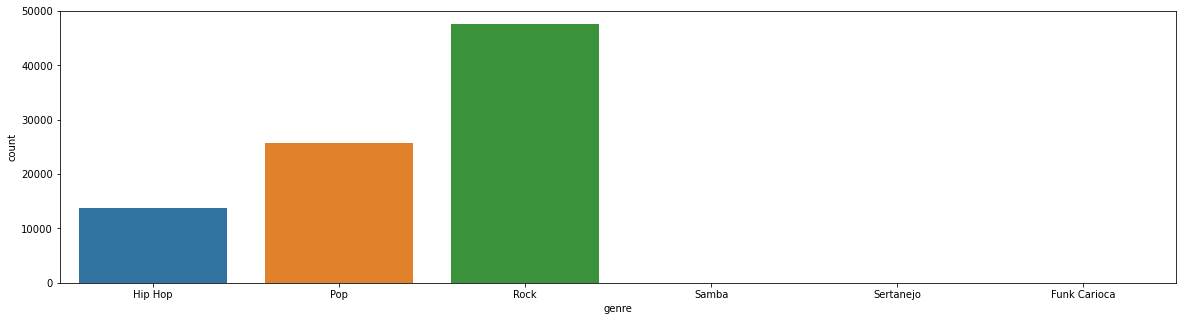

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

from helper import get_fresh_copy

plt.figure(figsize=(20, 5))
sns.countplot(data=get_fresh_copy(), x='genre')

## Frequency distribution

The second data to consider was a frequency distribution of the most common words in our dataset and look up how often they are used in the different genres. Based on the resulting information it should be possible to make assumptions about a song being in a certain genre because it uses certain words. The analysis was made with general processed data as well as optional preprocessed data to get a normalized version and compare the two results. In the end, as seen below, the distribution is more or less equal and not much of an information gain was accomplished. Initially the idea was to use stopwords as its own frequency distribution analysis as well, since different genres may use different stopwords. After the results were evaluated the stopwords were completly removed from the data, since no information was gained by them. At last one benefit of the data exists. With the distribution it can be checked if stop words are still in the data, since they are the most used words. Based on this data the decision was made to use gensim to further remove stopwords, since in the original data not all were removed.

In [28]:
import itertools
import nltk
import pandas as pd

def lengthDistribution(data_df):
    genres = data_df.genre.unique()

    lengthDistribution
    df_container = {}
    fd_container = {}

    total_word_count = {}

    merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(data_df['lyric'])).items(), columns=['words', 'frequency'])
    merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

    for genre in genres:
        df_container[genre] = data_df[data_df.genre.eq(genre)]
        fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
        total_word_count[genre] = sum(fd_container[genre].values())
        fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
        fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
        merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
    merged_fd_df = merged_fd_df.set_index('words')
    
    return merged_fd_df

### General preprocessed dataset

The figure shows the frequency distribution of words in the different genres. The most word used is "nt", which maps to "not". The only really relevant data gathere here is that Funkt Carioca could be identified by use the words "know", "like" or "love" but since there are only a tiny number of Funk Carioca songs in the data, it may be just a coincidence and there is no definitv answer to be made here. As seen the rest of the date behaves more or less the same from start to begining.

<AxesSubplot:xlabel='words'>

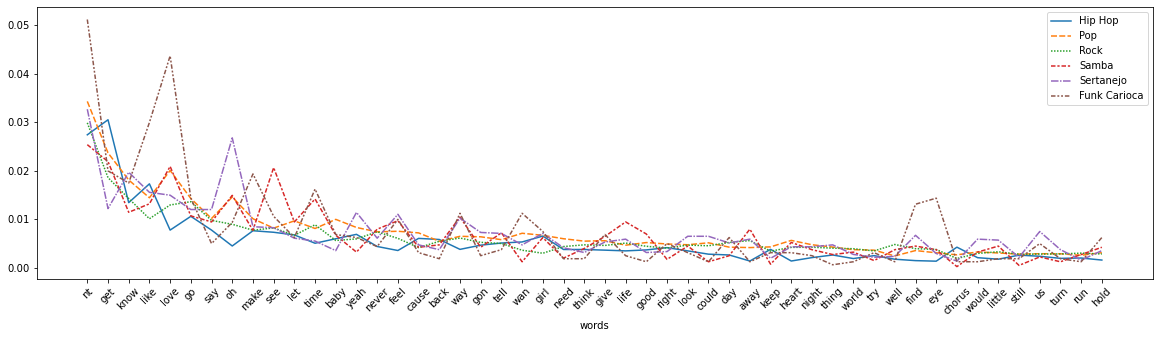

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_flatted_copy

        
length_distribution_df = lengthDistribution(get_fresh_flatted_copy(1))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

### Optional preprocessed dataset

In the optionale preprocessed data, no new information prevails compared to the data used before.

<AxesSubplot:xlabel='words'>

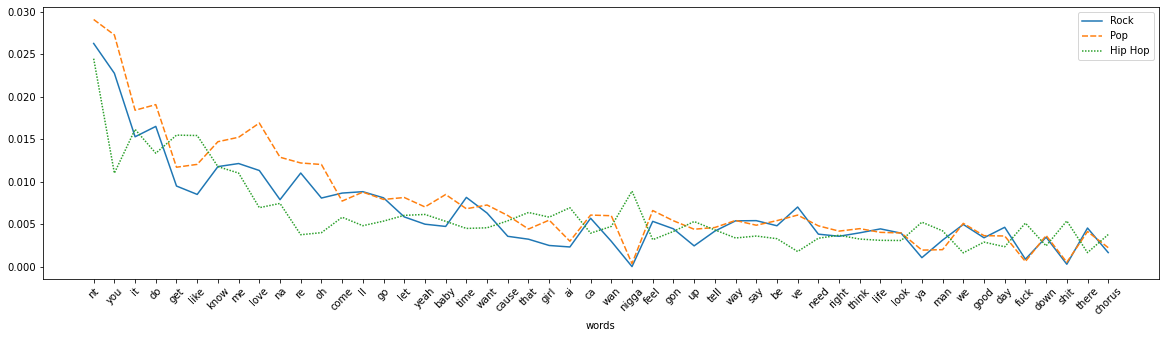

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_copy

        
length_distribution_df = lengthDistribution(get_fresh_copy(opt=True))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

## Distribution of lyric length by genre (word based)

The next approach taken was to analyze the length of the lyrics based on the number of used words. The goal of this was to better differentiate between genres and hopefully get relevant information to work with. Again the general preprocessed dataset was used as well as the optional preprocessed dataset. Overall the results were not perfect but with "Hip Hop" having longer songs on average then any other genre, at least a little claryfication was gathered. To further show this both dataset present the same result which proves the point of "Hip Hop" songs being the longest, even more. The rest of the genres are all more or less the same considering the length if shown on the general dataset. Moving to the optional preprocessed data, the diagram shows a slight difference. On average it is shown that Rock songs are slightly shorter than pop songs which may be just a little difference, but further clarifys the genreall idea of the data struktur.

In [31]:
import pickle

def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

### General preprocessed dataset

As allready the discribed the grpah with the general preprocessed dataset shows a the length of a song by genre. Furthermore a cluster development can be seen, which is the basis for our results.  

<AxesSubplot:xlabel='length', ylabel='count'>

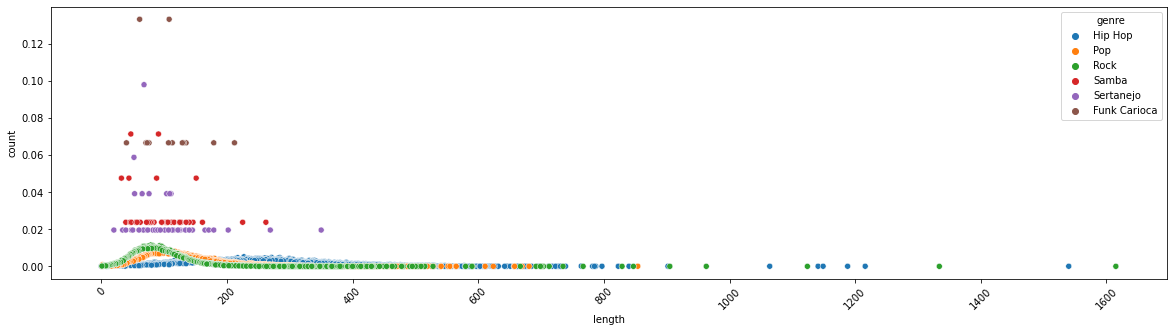

In [32]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

### Optional preprocessed dataset

The graph based on the optional preprocessed dataset which further and clearer shows the cluster development. Now the differences in length of songs, in a genre can easily be seen and serve as the base for our evaluation that most Rock and Pop songs are less than 200 words long (after removing stopwords) while Hip Hop contains the longest songs, some of which contain more than 600 words and Pop songs are slightly longer than rock songs.

<AxesSubplot:xlabel='length', ylabel='count'>

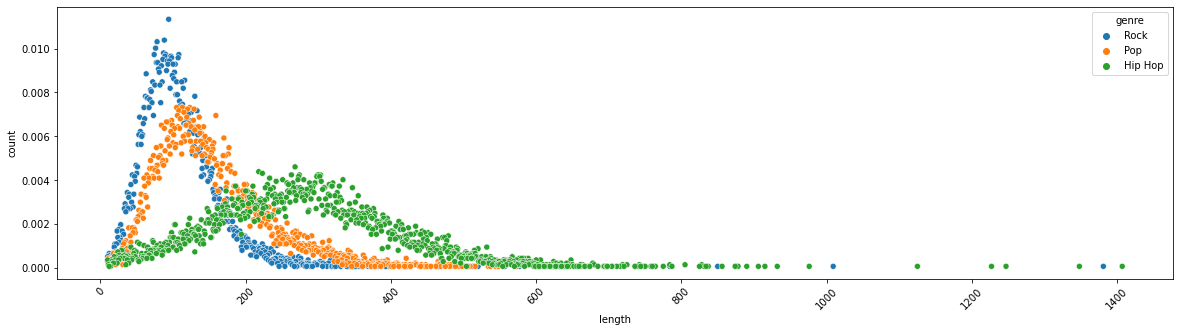

In [33]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_copy(opt=True)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

## Distribution of lyric length by genre (verse based)

The second length based approach was to look at the distribution of lyric length based on the length of a whole verse instead of just a single word. Taking the gained results, the plan was to further confirm the previous results, namely rock being the shortest and Pop being a little bit longer then rock on average. Since the optional preprocessed data was only usable as a flattened dataframe, it was not possible to use on verses, considering the verse structure was dropped out of it. Still with the general preprocessed data the result was slightly different, because now Rock and Pop are practically equivalent to each other while the other data depicts the same results.

<AxesSubplot:xlabel='length', ylabel='count'>

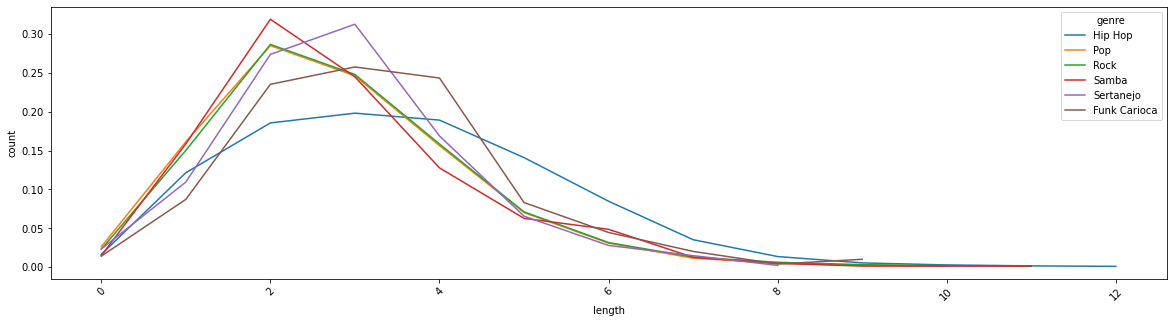

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy, melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Distribution of lyric length by genre (lyrics/verse based)

The last approach was to analyze the length of a lyric based on the length of the words contained in a verse. Again the optional preprocessed data frame can not be used for the same reasons as described before. Surprisingly the results shown in the graph depict the exact difference to the approach of just analyzing verses. The results show that, while Rock is still the shortest it wanders even more to the left side of the graph, while Pop and HipHop more or less stays the same. Based on this data it is shown that the distinction of rock being the shortest, pop being in the middle and HipHip being the longest can safely be assumed. If the structure of the data is based on the length of the words contained in a verse.

<AxesSubplot:xlabel='length', ylabel='count'>

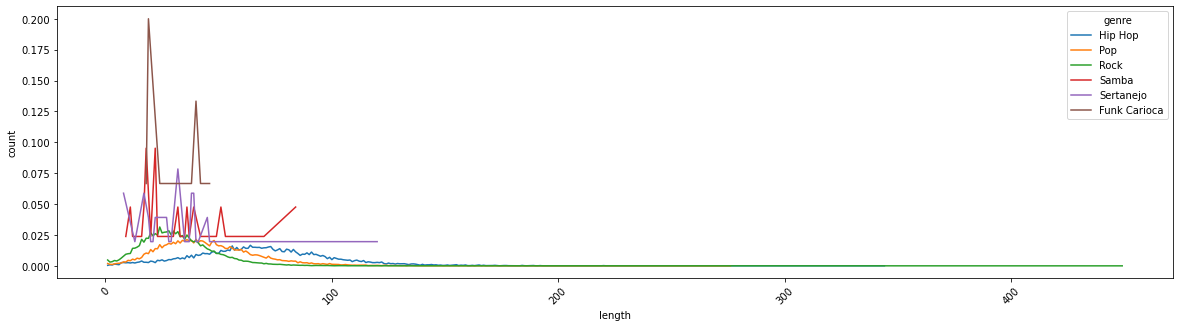

In [35]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df, x="length", y="count", hue="genre")

# Learning

## Baselines

In [29]:
#TODO: MOVE to ende

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=10)
dummy.fit(g_x_train, g_y_train)
most_frequent_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always choosing the most frequent label: ", most_frequent_score) # always predicts most frequent label

dummy = DummyClassifier(strategy="uniform", random_state=10)
dummy.fit(g_x_train, g_y_train)
uniform_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always predicting label at random: ", uniform_score) # random prediction

dummy = DummyClassifier(strategy="stratified", random_state=10, constant="rock")
dummy.fit(g_x_train, g_y_train)
stratified_score = dummy.score(g_x_test, g_y_test)
print("Baseline by respecting the training sets class distribution: ", stratified_score) # prediction by respecting the training sets class distribution

Baseline by always choosing the most frequent label:  0.5470713097355286
Baseline by always predicting label at random:  0.01715334748436693
Baseline by respecting the training sets class distribution:  0.2177155642246572


## Simple Neural Networks

In [27]:
# Move to Helper
#https://stackoverflow.com/questions/42406233/how-to-add-title-to-seaborn-boxplot
def print_graph(history_a, history_b):
    history_df = pd.DataFrame(history_a.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title('General Data')

    history_df = pd.DataFrame(history_b.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title("Optional Data")

### Prepare Data

In [28]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
    tokenizer = Tokenizer(num_words=10000)

    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    tokenizer.fit_on_texts(x_train)

    x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

g_x_train, g_x_test, g_y_train, g_y_test, g_num_classes = prepData(get_fresh_flatted_copy())
o_x_train, o_x_test, o_y_train, o_y_test, o_num_classes = prepData(get_fresh_copy(opt=1))

## Baselines

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=10)
dummy.fit(g_x_train, g_y_train)
most_frequent_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always choosing the most frequent label: ", most_frequent_score) # always predicts most frequent label

dummy = DummyClassifier(strategy="uniform", random_state=10)
dummy.fit(g_x_train, g_y_train)
uniform_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always predicting label at random: ", uniform_score) # random prediction

dummy = DummyClassifier(strategy="stratified", random_state=10, constant="rock")
dummy.fit(g_x_train, g_y_train)
stratified_score = dummy.score(g_x_test, g_y_test)
print("Baseline by respecting the training sets class distribution: ", stratified_score) # prediction by respecting the training sets class distribution

### Shallow Neural Network

#### General Data

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict = history_g.history
acc_g = history_g_dict['accuracy']
vacc_g = history_g_dict['val_accuracy']
loss_g = history_g_dict['loss']
vloss_g = history_g_dict['val_loss']


score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6960 - accuracy: 0.7109 - val_loss: 0.5817 - val_accuracy: 0.7600
Epoch 2/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5484 - accuracy: 0.7709 - val_loss: 0.5801 - val_accuracy: 0.7619
Epoch 3/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4810 - accuracy: 0.8015 - val_loss: 0.5939 - val_accuracy: 0.7556
Epoch 4/5
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4349 - accuracy: 0.8220 - val_loss: 0.6414 - val_accuracy: 0.7527
Epoch 5/5
545/545 [==============================] - 1s 1ms/step - loss: 0.6760 - accuracy: 0.7484


#### Optional Data

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict = history_o.history
acc_o = history_o_dict['accuracy']
vacc_o = history_o_dict['val_accuracy']
loss_o = history_o_dict['loss']
vloss_o = history_o_dict['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7066 - accuracy: 0.6803 - val_loss: 0.6201 - val_accuracy: 0.7220
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5307 - accuracy: 0.7753 - val_loss: 0.6394 - val_accuracy: 0.7205
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.4354 - accuracy: 0.8165 - val_loss: 0.6892 - val_accuracy: 0.7226
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.3665 - accuracy: 0.8505 - val_loss: 0.7395 - val_accuracy: 0.7193
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.8007 - accuracy: 0.7266


#### Results

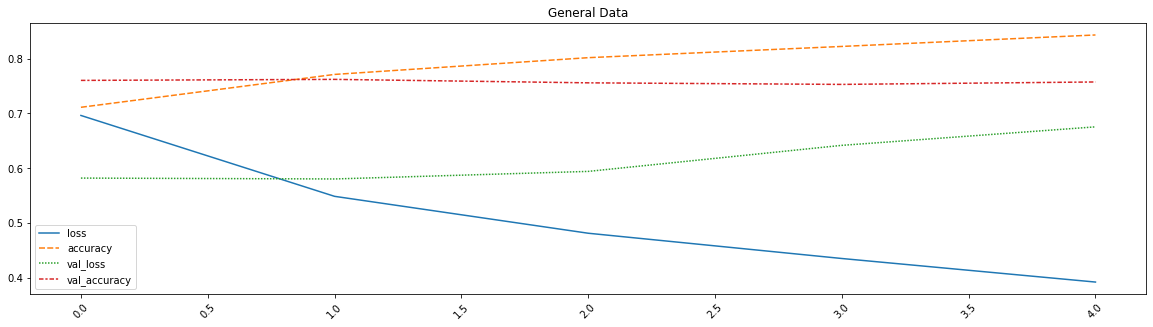

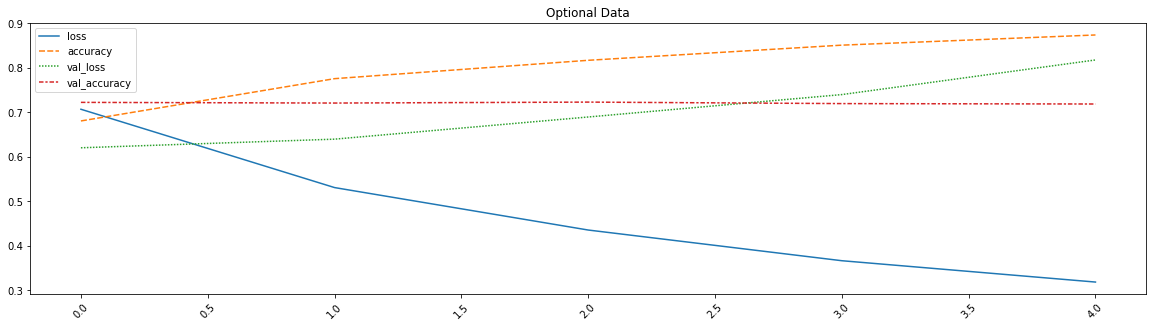

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Deep Dense Neural Network

#### General Data

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_deep = history_g.history
acc_g_deep = history_g_dict_deep['accuracy']
vacc_g_deep = history_g_dict_deep['val_accuracy']
loss_g_deep = history_g_dict_deep['loss']
vloss_g_deep = history_g_dict_deep['val_loss']

score_g_deep = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.7401 - accuracy: 0.6835 - val_loss: 0.6439 - val_accuracy: 0.7106
Epoch 2/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6122 - accuracy: 0.7465 - val_loss: 0.6349 - val_accuracy: 0.7332
Epoch 3/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.5567 - accuracy: 0.7739 - val_loss: 0.5928 - val_accuracy: 0.7440
Epoch 4/5
1961/1961 [==============================] - 4s 2ms/step - loss: 0.5094 - accuracy: 0.7962 - val_loss: 0.6110 - val_accuracy: 0.7433
Epoch 5/5
545/545 [==============================] - 1s 1ms/step - loss: 0.6205 - accuracy: 0.7442


#### Optional Data

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_deep = history_o.history
acc_o_deep = history_o_dict_deep['accuracy']
vacc_o_deep = history_o_dict_deep['val_accuracy']
loss_o_deep = history_o_dict_deep['loss']
vloss_o_deep = history_o_dict_deep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 2s 2ms/step - loss: 0.7911 - accuracy: 0.6144 - val_loss: 0.7477 - val_accuracy: 0.6370
Epoch 2/5
923/923 [==============================] - 2s 2ms/step - loss: 0.6688 - accuracy: 0.7032 - val_loss: 0.6728 - val_accuracy: 0.6824
Epoch 3/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5953 - accuracy: 0.7463 - val_loss: 0.6358 - val_accuracy: 0.7095
Epoch 4/5
923/923 [==============================] - 2s 2ms/step - loss: 0.5377 - accuracy: 0.7717 - val_loss: 0.6509 - val_accuracy: 0.7050
Epoch 5/5
257/257 [==============================] - 0s 1ms/step - loss: 0.6552 - accuracy: 0.7075


#### Results

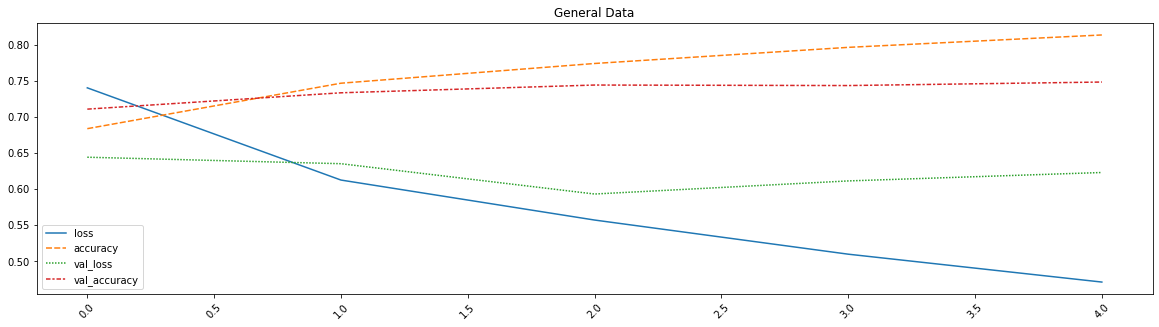

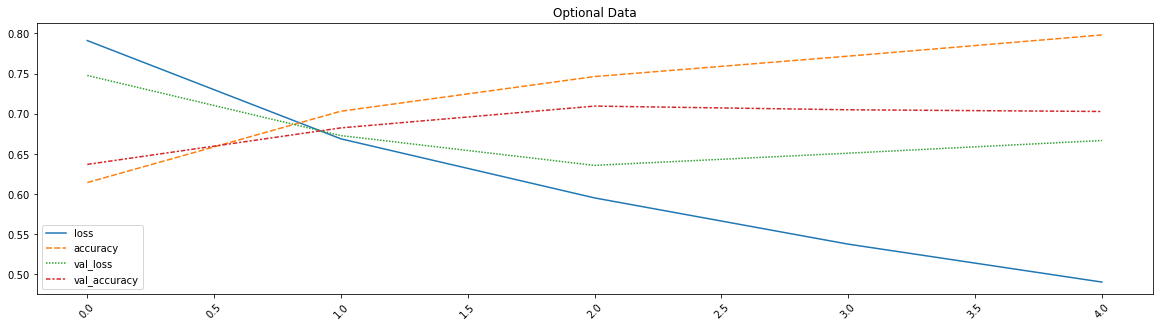

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Big Deep Dense Neural Network

#### General Data

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_bigdeep = history_g.history
acc_g_bigdeep = history_g_dict_bigdeep['accuracy']
vacc_g_bigdeep = history_g_dict_bigdeep['val_accuracy']
loss_g_bigdeep = history_g_dict_bigdeep['loss']
vloss_g_bigdeep = history_g_dict_bigdeep['val_loss']

score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
1961/1961 [==============================] - 27s 14ms/step - loss: 0.8113 - accuracy: 0.6884 - val_loss: 0.6478 - val_accuracy: 0.7390
Epoch 2/5
1961/1961 [==============================] - 24s 12ms/step - loss: 0.6964 - accuracy: 0.7375 - val_loss: 0.6970 - val_accuracy: 0.7085
Epoch 3/5
1961/1961 [==============================] - 24s 12ms/step - loss: 0.6385 - accuracy: 0.7668 - val_loss: 0.9004 - val_accuracy: 0.7005
Epoch 4/5
1961/1961 [==============================] - 25s 13ms/step - loss: 0.6338 - accuracy: 0.7819 - val_loss: 2.1545 - val_accuracy: 0.6634
Epoch 5/5
545/545 [==============================] - 1s 3ms/step - loss: 1.3504 - accuracy: 0.6991


#### Optional Data

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_bigdeep = history_o.history
acc_o_bigdeep = history_o_dict_bigdeep['accuracy']
vacc_o_bigdeep = history_o_dict_bigdeep['val_accuracy']
loss_o_bigdeep = history_o_dict_bigdeep['loss']
vloss_o_bigdeep = history_o_dict_bigdeep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/5
923/923 [==============================] - 15s 16ms/step - loss: 0.8526 - accuracy: 0.6521 - val_loss: 0.6864 - val_accuracy: 0.7089
Epoch 2/5
923/923 [==============================] - 11s 12ms/step - loss: 0.6068 - accuracy: 0.7527 - val_loss: 0.8535 - val_accuracy: 0.6803
Epoch 3/5
923/923 [==============================] - 12s 13ms/step - loss: 0.5383 - accuracy: 0.8123 - val_loss: 0.8680 - val_accuracy: 0.7004
Epoch 4/5
923/923 [==============================] - 11s 12ms/step - loss: 0.4434 - accuracy: 0.8622 - val_loss: 1.3013 - val_accuracy: 0.7147
Epoch 5/5
257/257 [==============================] - 1s 3ms/step - loss: 1.0863 - accuracy: 0.6993


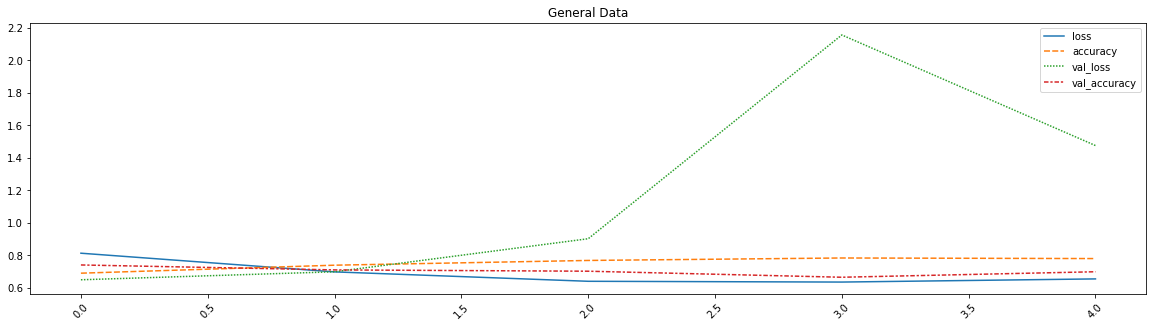

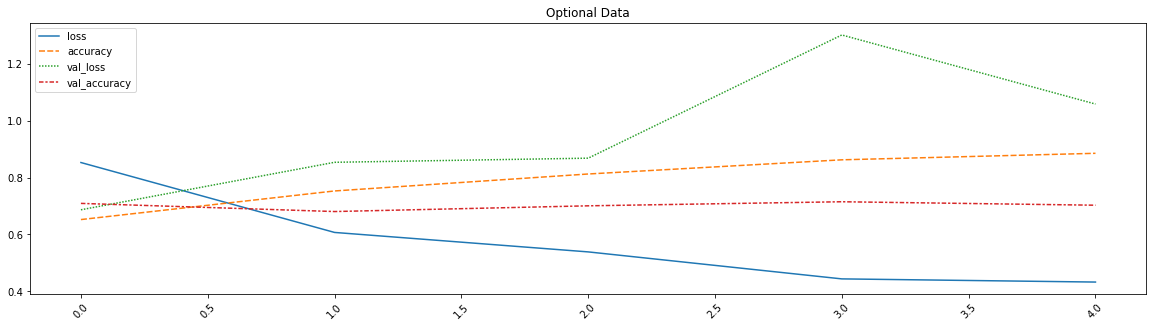

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Verso

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_v = model.fit(v_x_train, v_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_v_dict_bigdeep = history_v.history
acc_v_bigdeep = history_v_dict_bigdeep['accuracy']
vacc_v_bigdeep = history_v_dict_bigdeep['val_accuracy']
loss_v_bigdeep = history_v_dict_bigdeep['loss']
vloss_v_bigdeep = history_v_dict_bigdeep['val_loss']

score_o = model.evaluate(v_x_test, v_y_test, batch_size=batch_size, verbose=1)


import pandas as pd
songs_df = get_fresh_copy(0.1)
songs_df['pred'] = songs_df['lyric'].transform(lambda x: pd.DataFrame(data=model.predict_classes(x, verbose=1), column=['verse_pred'])


wrong = 0
right = 0

songs_df['pred'] = songs_df['pred'].value_counts().idxmax()


## Complex Neural Networks

In [ ]:
MAX_SEQUENCE_LENGTH = 400
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Prepare Data

load data and factorize 'genre'

#### Load Data

In [ ]:
import pandas as pd
from helper import melt, get_fresh_flatted_copy

preprocessed_df = pd.DataFrame(get_fresh_flatted_copy(1))

#https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
preprocessed_df.genre = pd.factorize(preprocessed_df.genre)[0]

In [42]:
display(preprocessed_df)

,sname,lyric,artist,genre
51949,My Dream (feat. Akon),"[intro, akon, chamillionaire, remember, loner,...",Chamillionaire,0
64994,Gone Til November (the Makin' Runs Remix),"[wyclef, jean, feat, canibus, kelly, khadejiah...",Wyclef Jean,0
51740,You're Everything,"[bun, talk, man, fo, real, love, dirty, south,...",Bun-b,0
20431,Now It's Not Enough,"[weak, powerless, taste, oh, well, game, empty...",Kerli,1
42178,Love Yer Brain,"[do, nt, know, think, world, guy, burnin, stre...",The Flaming Lips,2
...,...,...,...,...
21440,Always On The Run (feat. Slash),"[mama, say, life, gift, mama, say, there, weig...",Lenny Kravitz,2
73349,Fluorescent,"[sayin, nothin, do, nt, know, know, you, re, d...",Gwen Stefani,1
50057,Talk Of The Town,"[people, gon, talk, that, do, top, gon, hate, ...",50 Cent,0
5192,I Want To Drag You Around,"[wan, na, drag, around, wan, na, drag, around,...",Blondie,2


save needed dataframes as arrays and hot-encode the label

In [ ]:
import numpy as np
from keras.utils import to_categorical

labels_index = preprocessed_df['genre'].unique()
texts = np.asarray(preprocessed_df['lyric'])
labels = np.asarray(preprocessed_df['genre'])

labels = to_categorical(np.asarray(labels))

convert lyrics to verctors and pad the result

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


#### Split Data
split the data into a training set and a validation set

In [ ]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#### Build embedding layer

#### pre-trained embedding

load the pre-trained glove-model

In [ ]:
from helper import loadGloveModel

embeddings_index = loadGloveModel()

build the embedding-matrix 

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

build the embedding-lyer

In [ ]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### not pre-trained embedding

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

### Convolutional Neural Network with MaxPooling

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

innter_layer = Conv1D(128, 5, activation='relu')(embedded_sequences)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = GlobalMaxPooling1D()(innter_layer)
innter_layer = Dense(64, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(32, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(16, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)

output_1 = Dense(len(labels_index), activation='softmax')(innter_layer)

model = Model(sequence_input, output_1)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_convolutionalPooling = history.history
acc_convolutionalPooling = history_dict_convolutionalPooling['acc']
vacc_convolutionalPooling = history_dict_convolutionalPooling['val_acc']
loss_convolutionalPooling = history_dict_convolutionalPooling['loss']
vloss_convolutionalPooling = history_dict_convolutionalPooling['val_loss']

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

### Recurrent Bidirectional Neural Network

In [ ]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential


model = Sequential()
model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Dropout(0.1))
model.add(Bidirectional(GRU(16, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8)))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_recurrentBidirectional = history.history
acc_recurrentBidirectional = history_dict_recurrentBidirectional['acc']
vacc_recurrentBidirectional = history_dict_recurrentBidirectional['val_acc']
loss_recurrentBidirectional = history_dict_recurrentBidirectional['loss']
vloss_recurrentBidirectional = history_dict_recurrentBidirectional['val_loss']

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

# Classic Machine Learning

In [ ]:
import pandas as pd
from sklearn import preprocessing, metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from helper import get_fresh_flatted_copy

def prepr_count_vectors_word(data):
    trainDF = pd.DataFrame()
    trainDF['lyric'] = data['lyric']
    trainDF['genre'] = data['genre']

    trainDF['lyric'] = [" ".join(lyric) for lyric in trainDF['lyric'].values] 
    
    train_x, test_x, train_y, test_y = model_selection.train_test_split(trainDF['lyric'], trainDF['genre'])
    
    encoder = preprocessing.LabelEncoder()
    train_y = encoder.fit_transform(train_y)
    test_y = encoder.fit_transform(test_y)
    
    count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
    count_vect.fit(trainDF['lyric'])
    
    xtrain_count = count_vect.transform(train_x)
    xtest_count = count_vect.transform(test_x) 
    
    return xtrain_count, xtest_count, train_y, test_y

#y_train = keras.utils.to_categorical(y_train)
#y_test = keras.utils.to_categorical(y_test)

In [ ]:
#https://pythonhealthcare.org/2018/12/15/104-using-free-text-for-classification-bag-of-words/
def create_bag_of_words(x):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 ngram_range = (1,2), \
                                 max_features = 10000
                                ) 

    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings. The output is a sparse array
def prepr_tfidf_vectors_word(data):
    trainDF = pd.DataFrame()
    trainDF['lyric'] = data['lyric']
    trainDF['genre'] = data['genre']
    
    trainDF['lyric'] = [" ".join(lyric) for lyric in trainDF['lyric'].values] 
    
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit(trainDF['lyric'])
    
    train_x, test_x, train_y, test_y = model_selection.train_test_split(trainDF['lyric'], trainDF['genre'])
    
    xtrain_tfidf = tfidf_vect.transform(train_x)
    xtest_tfidf = tfidf_vect.transform(test_x)
    
    return xtrain_tfidf, xtest_tfidf, train_y, test_y

    # Get words in the vocabulary
    vocab = vectorizer.get_feature_names()
   
    return vectorizer, vocab, train_data_features, tfidf_features, tfidf

In [ ]:
vectorizer, vocab, train_data_features, tfidf_features, tfidf  = create_bag_of_words(x_train)

In [ ]:
import pandas as pd
def naive_bayes():
    model = MultinomialNB()
    return model

def linear_model():
    model = LogisticRegression()
    return model

# Sort by raw count
bag_dictionary.sort_values(by=['count'], ascending=False, inplace=True)
# Show top 10
display(bag_dictionary.head(10))

In [ ]:
def train_logistic_regression(features, label):
    print ("Training the logistic regression model...")
    from sklearn.linear_model import LogisticRegression
    ml_model = LogisticRegression(C = 100,random_state = 0, max_iter=1000)
    ml_model.fit(features, label)
    print ('Finished')
    return ml_model

In [ ]:
# wenn datensatz klein ist muss man max_iter hochstellen damit es convergiert
ml_model = train_logistic_regression(tfidf_features, y_train)

In [ ]:
test_data_features = vectorizer.transform(x_test)
# Convert to numpy array
test_data_features = test_data_features.toarray()

In [ ]:
test_data_tfidf_features = tfidf.fit_transform(test_data_features)
# Convert to numpy array
test_data_tfidf_features = test_data_tfidf_features.toarray()

In [ ]:
import numpy as np
def train_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return metrics.accuracy_score(predictions, y_test)

df = get_fresh_flatted_copy(1)
naive_model = naive_bayes()
linear_model = linear_model()

# prepare data as count vectors and calculate accuracy
x_train, x_test, y_train, y_test = prepr_count_vectors_word(df)
acc_naive_bayes_count = train_model(naive_model, x_train, x_test, y_train, y_test)
acc_linear_model_count = train_model(linear_model, x_train, x_test, y_train, y_test)

# prepare data as tfidf (word) vectors and calculate accuracy
x_train, x_test, y_train, y_test = prepr_tfidf_vectors_word(df)
acc_naive_bayes_tfidf = train_model(naive_model, x_train, x_test, y_train, y_test)
acc_linear_model_tfidf = train_model(linear_model, x_train, x_test, y_train, y_test)

# Summery

## Base line

* baselines berechnen 
* Loss or Accuracy

## Comparing results

## Restriction

## Problems